In [12]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import time

import optax

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.vi import VIEngine
from mcjax.proba.banana2d import Banana2D

from mcjax.proba.gauss import GaussianDiag, GaussianFullCov, GaussianDiagMixture, GaussianFullMixture
from mcjax.util.plot_2d import evaluate_on_grid_2d, create_ellipse



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# initialize PRNG
key = jr.key(0)

In [14]:
dist = Banana2D.create()
params_banana = dist.init_params(noise_std=0.2)
logdensity = dist.log_prob_only(params=params_banana)
logdensity_batch = jax.vmap(logdensity)


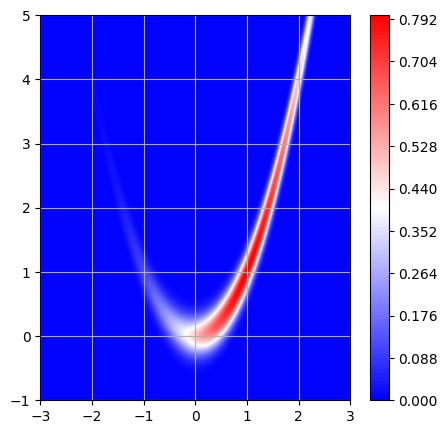

In [15]:
xmin, xmax = -3, 3
ymin, ymax = -1, 5
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()


In [5]:
approx_diag = GaussianDiag.create(dim=2)  # returns a Distribution instance
params_diag= approx_diag.init_params()  # initialize parameters
engine_diag = VIEngine.create(approx=approx_diag)

approx_full = GaussianFullCov.create(dim=2)
params_full = approx_full.init_params()  # initialize parameters
engine_full = VIEngine.create(approx=approx_full)

key, key_ = jr.split(key)
num_components_mix = 15
approx_mix = GaussianDiagMixture.create(dim=2, num_components=num_components_mix)
params_mix = approx_mix.init_params(key=key_)  # initialize parameters
engine_diag_mix = VIEngine.create(approx=approx_mix)

key, key_ = jr.split(key)
num_components_mix_full = 15
approx_mix_full = GaussianFullMixture.create(dim=2, num_components=num_components_mix_full)
params_mix_full = approx_mix_full.init_params(key=key_)  # initialize parameters
engine_diag_mix_full = VIEngine.create(approx=approx_mix_full)


approx_name_list = ['diag', 'full', 'mix', 'mix_full']
approx_list = [approx_diag, approx_full, approx_mix, approx_mix_full]
params_init_list = [params_diag, params_full, params_mix, params_mix_full]
engine_list = [engine_diag, engine_full, engine_diag_mix, engine_diag_mix_full]

In [6]:
optimizer = optax.adam(learning_rate=1e-1)

In [7]:
n_samples = 100
n_iter = 10_000
vi_output_dict = {}

for approx_name, params_init, engine in zip(approx_name_list, params_init_list, engine_list):
    print(f'Running {approx_name} approximation')
    params = params_init


    start_time = time.time()
    results = engine.run(
        params_init=params,
        log_prob=logdensity,
        key=key,
        optimizer=optimizer,
        n_samples=n_samples,
        n_iter=n_iter,
        verbose=False,
    )
    end_time = time.time()
    final_kl = results["kl_trace"][-1]
    print(f'\t Elapsed time: {end_time - start_time:.2f} seconds \t Final KL: {final_kl:.4f}')
    
    vi_output_dict[approx_name] = results
    

Running diag approximation
	 Elapsed time: 2.36 seconds 	 Final KL: 1.2580
Running full approximation
	 Elapsed time: 2.56 seconds 	 Final KL: 0.8774
Running mix approximation
	 Elapsed time: 8.84 seconds 	 Final KL: -0.0003
Running mix_full approximation
	 Elapsed time: 12.02 seconds 	 Final KL: -0.2144


In [ ]:
# compute the minimum of all negElbo for plotting
kl_all = jnp.concatenate([vi_output_dict[approx_name]["kl_trace"] for approx_name in approx_name_list], axis=0)
kl_min = jnp.min(kl_all)-0.1

# plot the results
for approx_name in approx_name_list:
    plt.plot(
        vi_output_dict[approx_name]["kl_trace"] - kl_min,
        label=f'{approx_name} (KL={vi_output_dict[approx_name]["kl_trace"][-1]:.2f})',
        alpha=0.8,
    )
plt.yscale('log')

# add label and legend
plt.xlabel('Iteration')
plt.ylabel('neg ELBO')
plt.grid(which="major", linestyle='-')
plt.grid(which="minor", linestyle='--', alpha=0.5)

# add legend upper right
plt.legend(loc='upper right')

In [ ]:
vi_output_dict["mix"]["params"]["components"][0]

In [ ]:
import matplotlib.pyplot as plt

# Create side-by-side plots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

########################
# Mean-field plot
########################
ax = axes[0,0]
# Extract final mean-field (diag) parameters
mu_diag = vi_output_dict["diag"]["params"]["mu"]
std_diag = vi_output_dict["diag"]["params"]["std"]
cov_diag = jnp.diag(std_diag ** 2)

# Add Ellipse
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.add_artist(create_ellipse(mu_diag, cov_diag, color='green', label='Mean-field'))
ax.plot(mu_diag[0], mu_diag[1], marker='*', color='black', markersize=3)
ax.legend(loc="upper left")

################
# Full covariance plot
################
ax = axes[0,1]
# Extract final full covariance parameters
mu_full = vi_output_dict["full"]["params"]["mu"]
cov_full = vi_output_dict["full"]["params"]["cov"]

ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.add_artist(create_ellipse(mu_full, cov_full, color='green', alpha=0.9, label='Full-covariance'))
ax.plot(mu_full[0], mu_full[1], marker='*', color='black', markersize=3)
ax.legend(loc="upper left")

################
# mixture diagonal
################
ax = axes[1,0]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

for k in range(num_components_mix):
    mu = vi_output_dict["mix"]["params"]["components"][k]["mu"]
    std = vi_output_dict["mix"]["params"]["components"][k]["std"]
    # mu = mus[k]
    # std = stds[k]
    cov = jnp.diag(std ** 2)
    if k==0:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.9, label='Mixture Diag'))
    else:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.9))
    ax.plot(mu[0], mu[1], marker='*', color='black', markersize=3)
# set the axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left")
plt.tight_layout()

# ################
# # mixture full
# ################
ax = axes[1,1]
# Extract final mixture parameters
# mus = vi_output_dict["mix_full"]["params"]["mu"]
# covs = vi_output_dict["mix_full"]["params"]["cov"]

ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

for k in range(num_components_mix_full):
    mu = vi_output_dict["mix_full"]["params"]["components"][k]["mu"]
    cov = vi_output_dict["mix_full"]["params"]["components"][k]["cov"]
    if k==0:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.9, label='Mixture Full'))
    else:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.9))
    ax.plot(mu[0], mu[1], marker='*', color='black', markersize=3)
# set the axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left")
plt.tight_layout()

### Generate samples from the variational family

In [ ]:
n_samples = 10_000
key, key_ = jr.split(key)

params_mix = vi_output_dict["mix"]["params_raw"]
samples_mix = approx_mix.sample(
    params=params_mix,
    key=key_,
    n_samples=n_samples
)

params_mix_full = vi_output_dict["mix_full"]["params_raw"]
samples_mix_full = approx_mix_full.sample(
    params=params_mix_full,
    key=key_,
    n_samples=n_samples
)

In [ ]:
# plot the density
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# mixture of diagonal Gaussians
ax = axes[0]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.scatter(samples_mix[:, 0], samples_mix[:, 1], s=1, color='black', alpha=0.3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Mixture of diagonal Gaussians samples')

# mixture of full Gaussians
ax = axes[1]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.scatter(samples_mix_full[:, 0], samples_mix_full[:, 1], s=1, color='black', alpha=0.3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title('Mixture of full Gaussians samples')

